In [1]:
import pubchempy as pcp #getting compounds from PubChem
from rdkit import Chem #importing RDKit to draw molecules
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display, Image

In [100]:

# Definições de padrões SMARTS para diferentes grupos funcionais
functional_groups = {
    'Álcool primário': '[!O]CO',  # Grupo hidroxila ligado a um carbono sp3
    'Aldeído': '[CH](=O)',  # Carbono duplamente ligado a oxigênio e ligado a um hidrogênio
    'Cetona': 'C(=O)',  # Carbono duplamente ligado a oxigênio e ligado a dois carbonos
    'Ácido carboxílico': '[C](=O)[OH]',  # Carbono duplamente ligado a oxigênio e ligado a um grupo hidroxila
    'Éster': 'C(=O)O',  # Carbono duplamente ligado a oxigênio e ligado a um oxigênio ligado a outro carbono
    'Amina primária': '[NH2;!$(NC=O)]',  # Nitrogênio ligado a um carbono sp3 e dois hidrogênios
    'Amina secundária': '[NH;!$(NC=O)]',  # Nitrogênio ligado a um carbono sp3 e um hidrogênio
    'Amina terciária': '[N;!H;!$(NC=O)]',  # Nitrogênio ligado a três carbonos sp3
    'Amida': '[NX3][CX3](=O)',  # Nitrogênio ligado a um carbono duplamente ligado a oxigênio
    'Éter': '[CX3]O[CX3]',  # Oxigênio ligado a dois carbonos sp3
    'Haleto de alquila': '[F,Cl,Br,I][CX4]',  # Halogênio ligado a um carbono sp3
    'Anel aromático': 'a',  # Qualquer átomo em um anel aromático
    'Fenol': 'c1ccccc1O[!C]',  # Anel aromático com hidroxila
    'Anilina': 'c1ccccc1N',  # Anel aromático com grupo amino
    'Tiol': '[SH]',  # Grupo tiol
    'Alceno':'C=C',
    'Alcino': 'C#C',  # Tripla ligação carbono-carbono
    'Nitrilo': '[CX2]#N',  # Tripla ligação carbono-nitrogênio
    'Imida': '[CX3](=O)[NX3](=O)',  # Grupo imida
    'Nitro': '[NX3](=O)=O',  # Grupo nitro
    'Sulfonamida': '[NX3][SX4](=O)(=O)',  # Grupo sulfonamida
    'Sulfonato': '[SX4](=O)(=O)[O-]',  # Grupo sulfonato
    'Tioéter': '[SX2][CX4]',  # Grupo tioéter
    'Ácido Sulfônico': '[SX4](=O)(=O)[OX2H1]',  # Grupo ácido sulfônico
    'Sulfoxida': '[#16X3](=[OX1])',  # Grupo sulfoxida
    'Sulfona': '[#16X4](=[OX1])(=[OX1])',  # Grupo sulfona
    'Peróxido': '[OX2][OX2]',  # Grupo peróxido
    'Anidrido': '[CX3](=[OX1])[OX2][CX3](=[OX1])',  # Grupo anidrido
    'Epóxido': '[CX4]1[OX2][CX4]1',  # Grupo epóxido
    'Tioalcoxi': '[#16][OX2]',  # Grupo tioalcoxi
    'Isocianato': '[NX2]=[CX2]=[OX1]',  # Grupo isocianato
    'Isotiocianato': '[NX2]=[CX2]=[SX1]',  # Grupo isotiocianato
    'Diazocomposto': '[NX2]=[NX2]',  # Grupo diazocomposto
    'Azido': '[NX3][NX2]=[NX1]',  # Grupo azido
    'Fosfina': '[PX3]',  # Grupo fosfina
    'Fosfato': '[PX4](=O)(O)(O)(O)',  # Grupo fosfato
    'Hidrato de Carbono': '[CX4][OX2H]',  # Hidrato de carbono (açúcar simples)
    'Glicósido': '[CX4][OX2][CX4]',  # Grupo glicósido
    'Enol': '[CX3]=[CX3][OX2H]',  # Grupo enol
    'Enamina': '[CX3]=[CX3][NX3;H2,H1;!$(NC=O)]',  # Grupo enamina
    'Azo': '[NX2]=[NX2]',  # Grupo azo
    'Hidrazona': '[NX3]=[CX3]',  # Grupo hidrazona
    'Hidroxilamina': '[NX3][OX2H]',  # Grupo hidroxilamina
    'Oximas': '[CX3](=N[OX2H1])',  # Grupo oximas
    'Isocianida': '[CX2]#[NX2]',  # Grupo isocianida
    'Imidoéster': '[CX3](=N)[OX2]',  # Grupo imidoéster
    'Carbamato': '[NX3][CX3](=O)[OX2]',  # Grupo carbamato
    'Ureia': '[NX3][CX3](=O)[NX3]',  # Grupo ureia
    'Guanidina': '[NX3][CX3](=N)[NX3]',  # Grupo guanidina
}


In [101]:

def identify_functional_groups(smiles):
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")
    
    identified_groups = {}
    
    for group_name, smarts in functional_groups.items():
        patt = Chem.MolFromSmarts(smarts)
        if mol2.HasSubstructMatch(patt):
            identified_groups[group_name] = mol2.GetSubstructMatches(patt)
    
    return identified_groups


In [102]:
def create_functional_groups_dataframe(identified_groups):
    group_counts = {group: len(matches) for group, matches in identified_groups.items()}
    df = pd.DataFrame(list(group_counts.items()), columns=['Função Orgânica', 'Quantidade'])
    return df

In [103]:
def draw_molecule_with_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")

    
    identified_groups = identify_functional_groups(smiles)
    drawer2 = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    opts = drawer2.drawOptions()
    
    highlight_atoms = []
    highlight_bonds = []
    highlight_colors = {}

    color_palette = [
        (1.0, 1.0, 0.0),  # Yellow
        (0.3, 1.0, 0.0),  # Green
        (0.2, 0.6, 1.0),  # Light Blue
        (1.0, 0.5, 0.0),  # Orange
        (1.0, 0.5, 1.0),  # Magenta
        (0.0, 1.0, 1.0),  # Cyan
    ]
    
    color_idx = 0
    
    for group_name, matches in identified_groups.items():
        color = color_palette[color_idx % len(color_palette)]
        color_idx += 1
        for match in matches:
            highlight_atoms.extend(list(match))
            highlight_colors.update({i: color for i in match})
            # Add bonds to the highlight list
            for i in range(len(match) - 1):
                bond = mol2.GetBondBetweenAtoms(match[i], match[i+1])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
            # Ensure to add the last bond in the functional group
            if len(match) > 2:
                bond = mol2.GetBondBetweenAtoms(match[-1], match[0])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
    
    drawer2.DrawMolecule(
        mol2,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        
        highlightAtomColors=highlight_colors,
    )
    drawer2.FinishDrawing()
    return drawer.GetDrawingText(), drawer2.GetDrawingText()


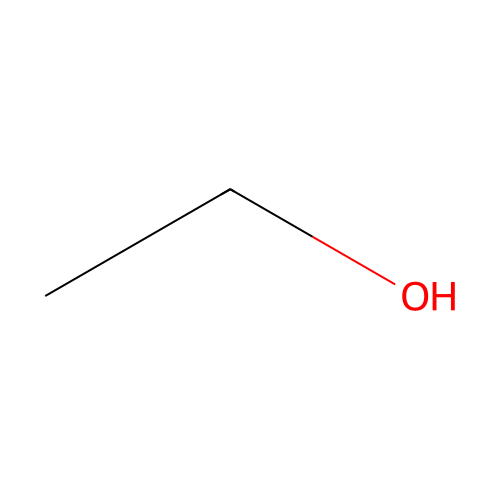

,Função Orgânica,Quantidade
0,Álcool primário,1
1,Hidrato de Carbono,1


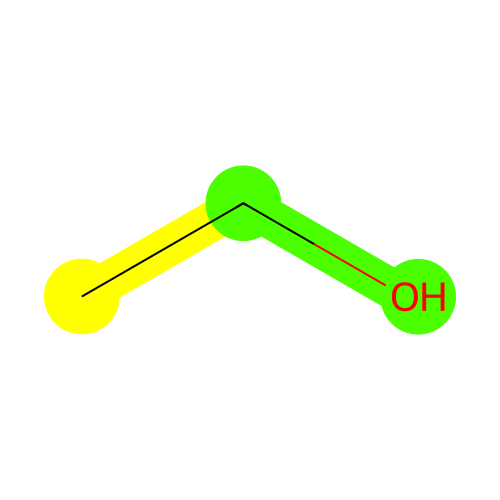

In [104]:
# Exemplo de uso
smiles = "CCO" 
identified_groups = identify_functional_groups(smiles)
img_data,img_data_groups = draw_molecule_with_functional_groups(smiles)
display(Image(img_data))
#cid = pcp.get_compounds(smiles, 'smiles')
#c = pcp.Compound.from_cid(cid[0].cid)
#print('IUPAC Name: ' + c.iupac_name)
#print('Molecular formula: ' + c.molecular_formula)
#print('Molecular weight: ' + c.molecular_weight + ' g/mol\n')

# Criar DataFrame
df = create_functional_groups_dataframe(identified_groups)
display(df)

display(Image(img_data_groups))
# Salva a imagem para um arquivo
with open('molecule.png', 'wb') as f:
    f.write(img_data_groups)